In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 18, 10

RANDOM_SEED = 42    # I'm seeding with 42, if you try the same you will get the same results.
np.random.seed(RANDOM_SEED)

# Loading the Data
Loading the data from the main source, it's gonna be updated daily.

In [2]:
# Loading the Data from the source
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,14,16,17,19,19,19,19,19,19,19


Choosing the country. aka. MOROCOO

In [3]:
df = df[df["Country/Region"]=="Morocco"]

Dropping the unnecessary rows

In [4]:
cumulative_daily_cases = df.iloc[:, 43:].transpose()
cumulative_daily_cases.head()

,163
3/1/20,0
3/2/20,1
3/3/20,1
3/4/20,1
3/5/20,2


Checking if there are any missing values

In [5]:
cumulative_daily_cases.isnull().sum()

163    0
dtype: int64

Making the formula of the dates look more nice.

In [6]:
cumulative_daily_cases.index = pd.to_datetime(cumulative_daily_cases.index)
cumulative_daily_cases.head()

,163
2020-03-01,0
2020-03-02,1
2020-03-03,1
2020-03-04,1
2020-03-05,2


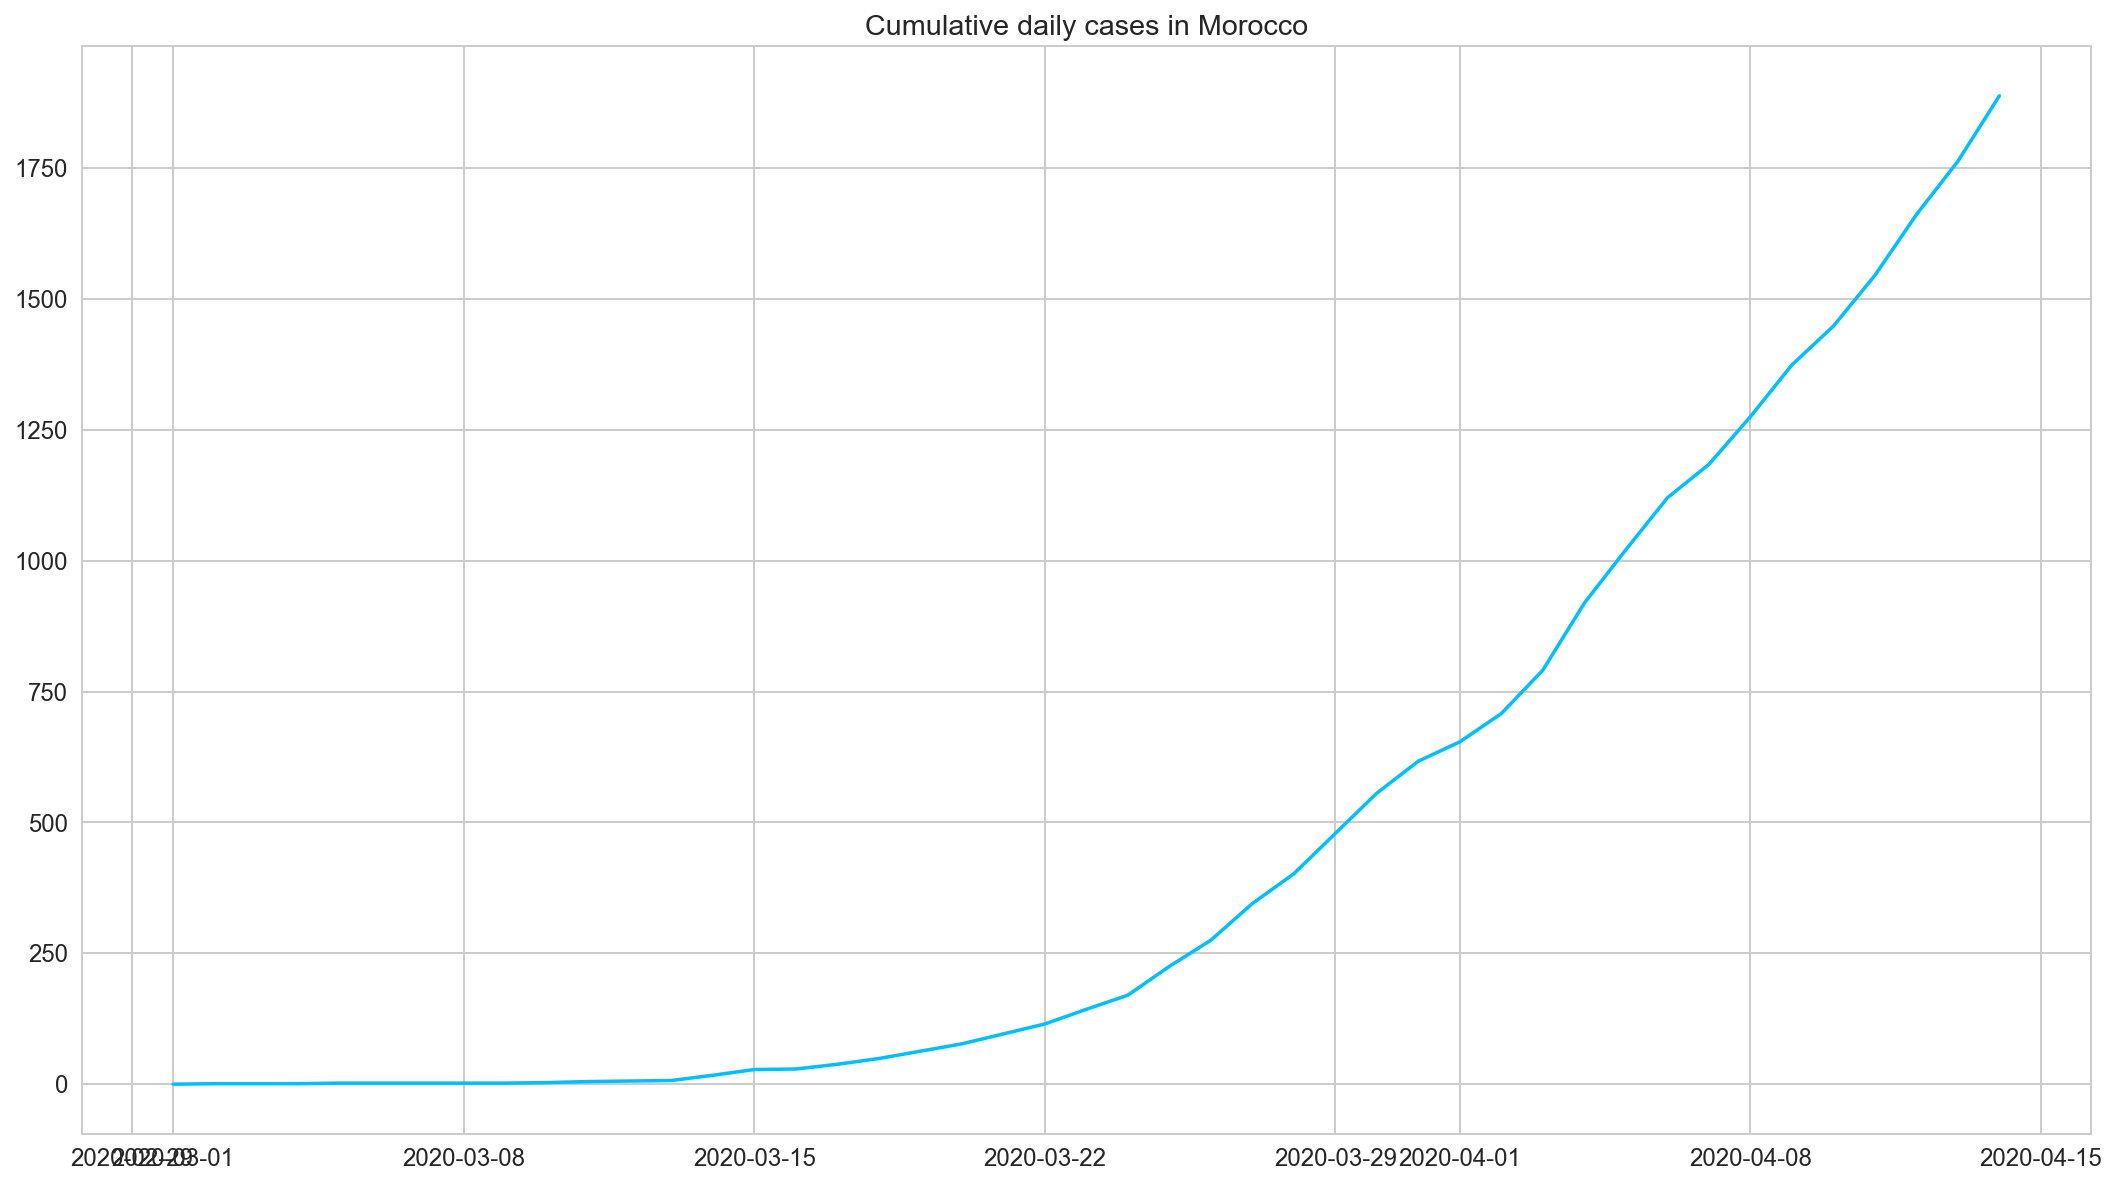

In [7]:
rcParams['figure.figsize'] = 18, 10
plt.plot(cumulative_daily_cases)
plt.title("Cumulative daily cases in Morocco");

Let's get the Daily Cases by reversing the cumulative method

In [8]:
daily_cases = cumulative_daily_cases.diff()
daily_cases = daily_cases.iloc[1:]
daily_cases.head()

,163
2020-03-02,1.0
2020-03-03,0.0
2020-03-04,0.0
2020-03-05,1.0
2020-03-06,0.0


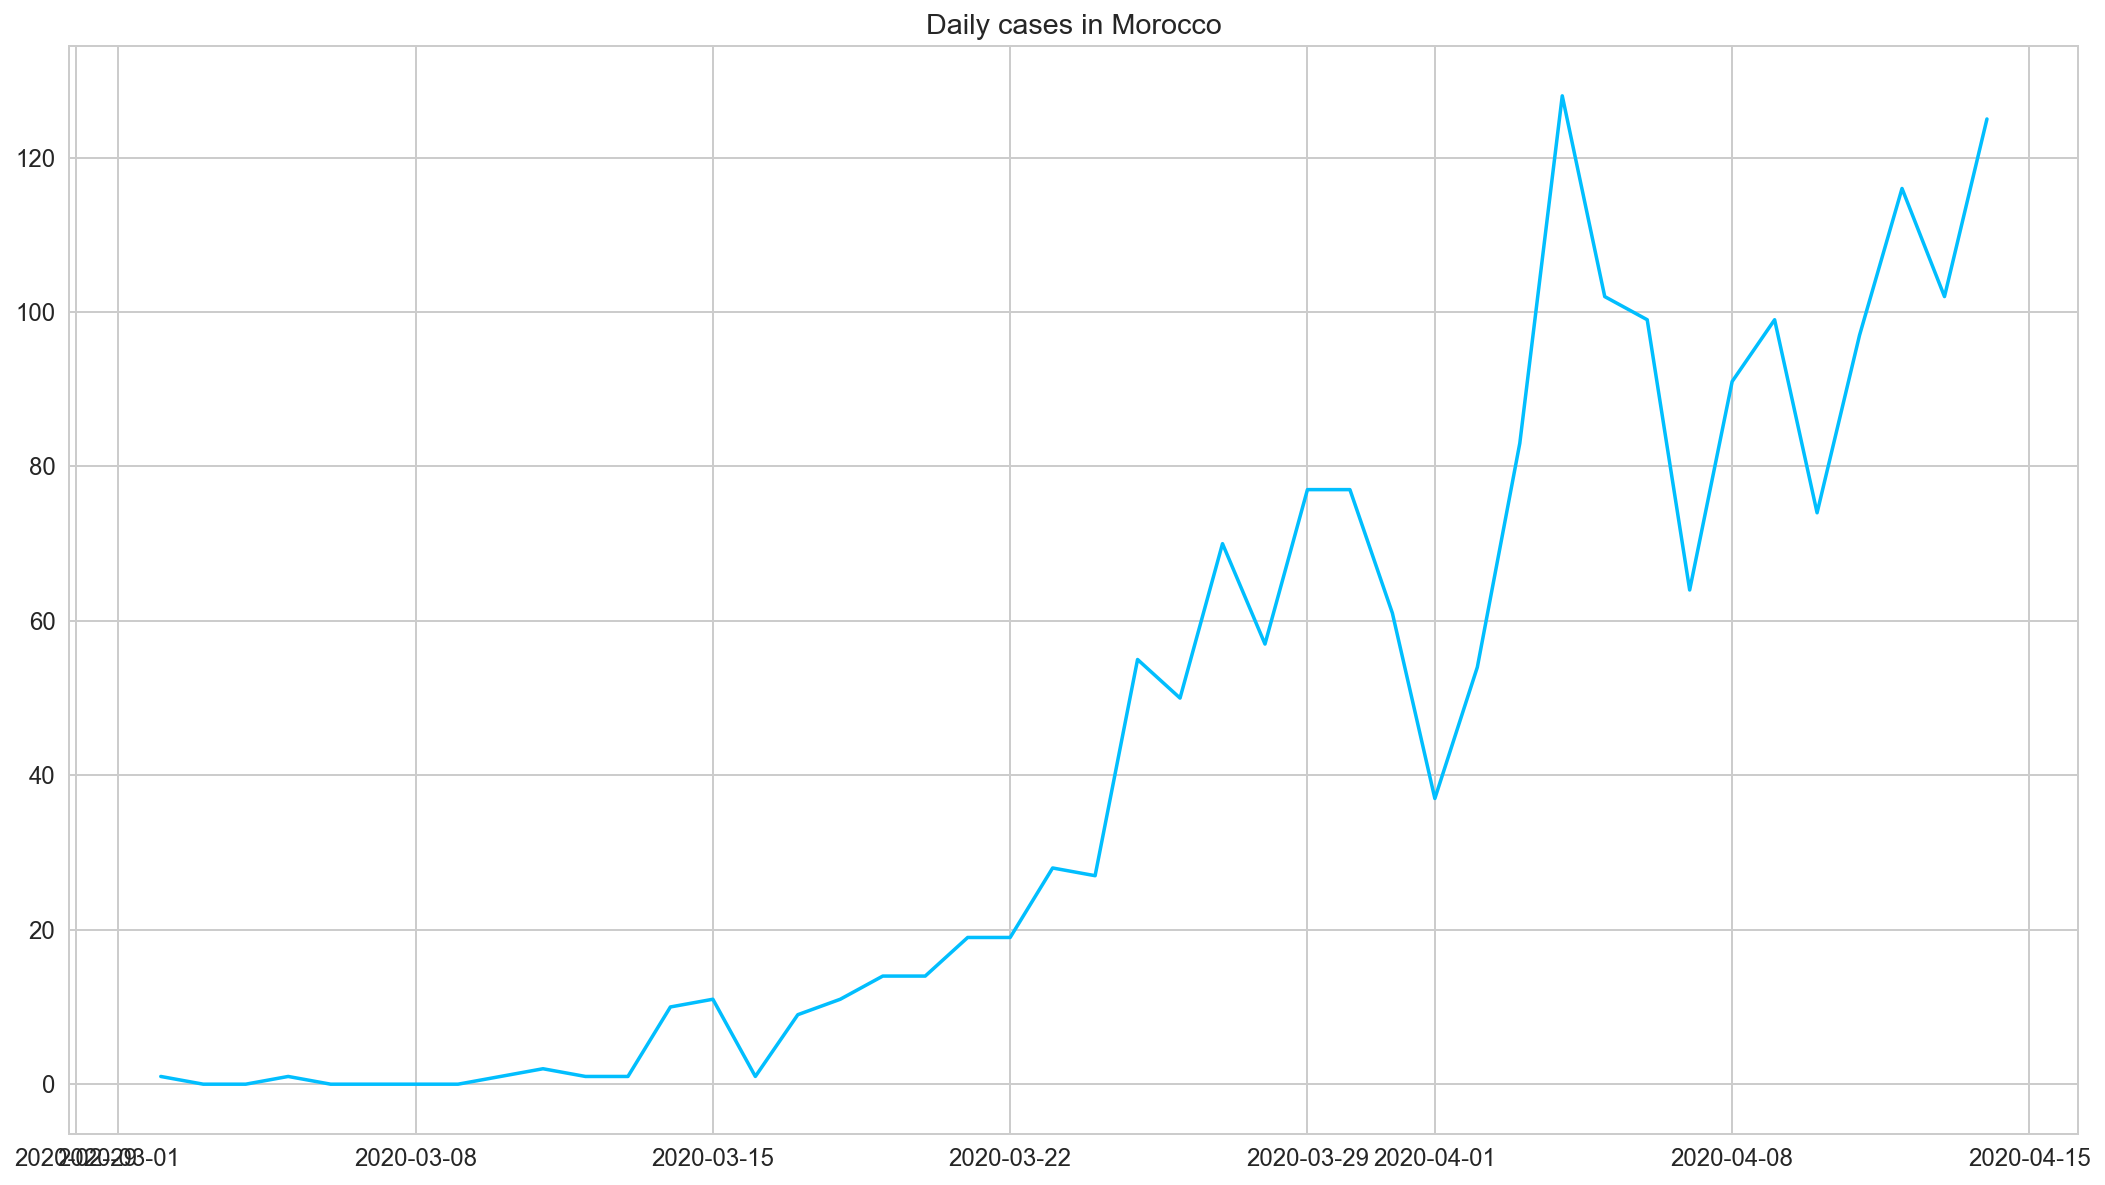

In [9]:
plt.plot(daily_cases)
plt.title("Daily cases in Morocco");

In [10]:
daily_cases.shape

(44, 1)

There we go. Now we have the updated Daily Cases of CoronaVirus in Morocco. So far we only have only 44 observed values (this number is going to increase as days will pass on, I'm writing this code in 15-04-2020). Now we have to choose either we play with Machine Learning Models (NN, Genetic Algorithms, Rnadom forest, SVR) or Statistical models (ARIMA for example). Since the length of the data is significantly small it's obvious that Machine Learning models will not do a good job because they normally need a larger data in order to learn from it.
In this demo, I'll play a bit with the model ARIMA(p,d,q). 
Here we goooooo...

# Modeling
First the data gets broken up into training and test.

In [11]:
# Leaving the last 5 days for testing.
train, test = daily_cases.iloc[:len(daily_cases) - 5], daily_cases.iloc[len(daily_cases) - 5:]

Just based on the graph of the series, it's quite obvious that it's not stationary (there is a trend).

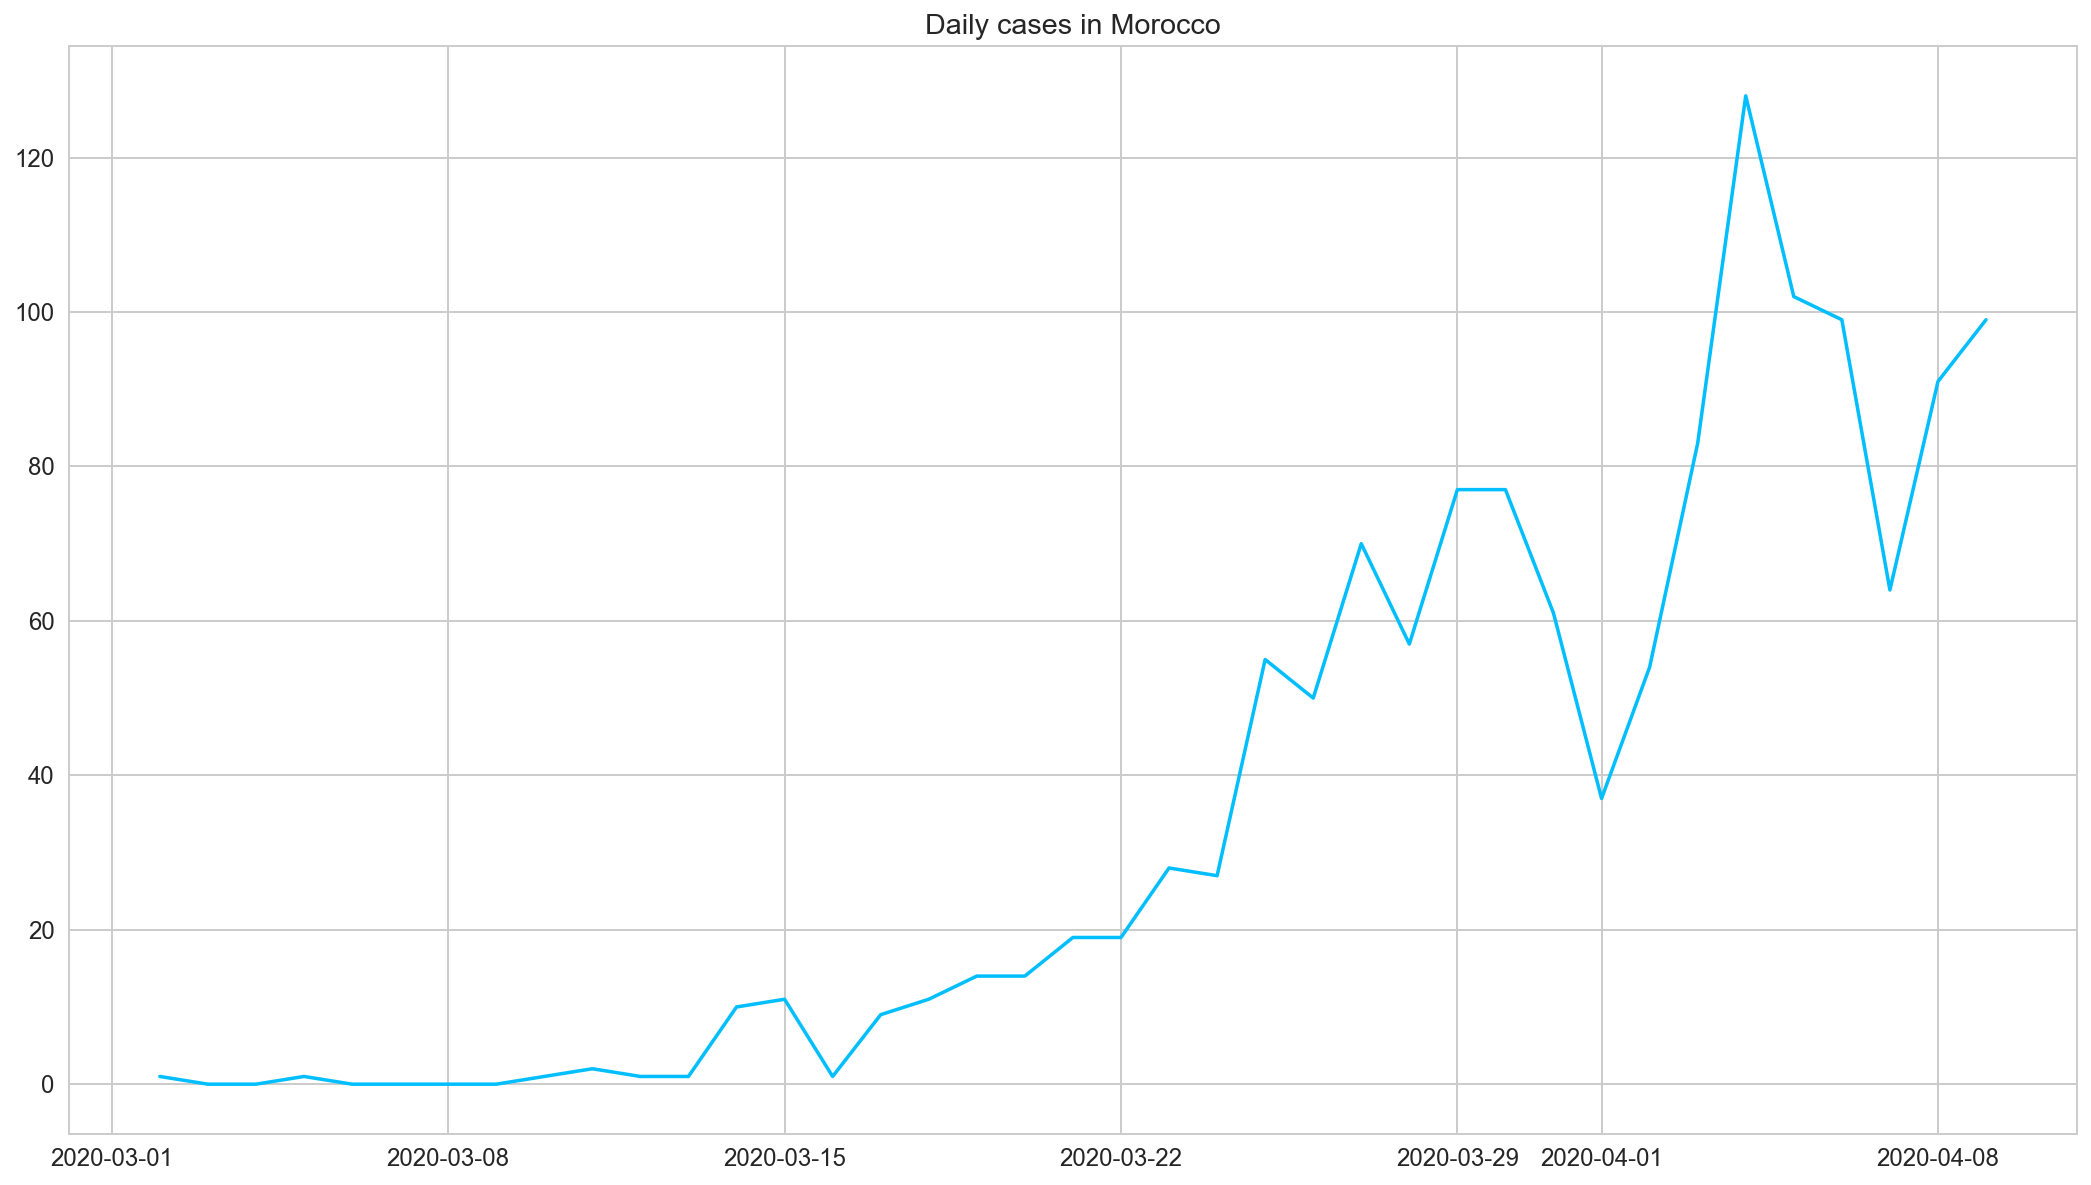

In [12]:
rcParams['figure.figsize'] = 18, 10

# Original Series
plt.plot(train)
plt.title("Daily cases in Morocco");

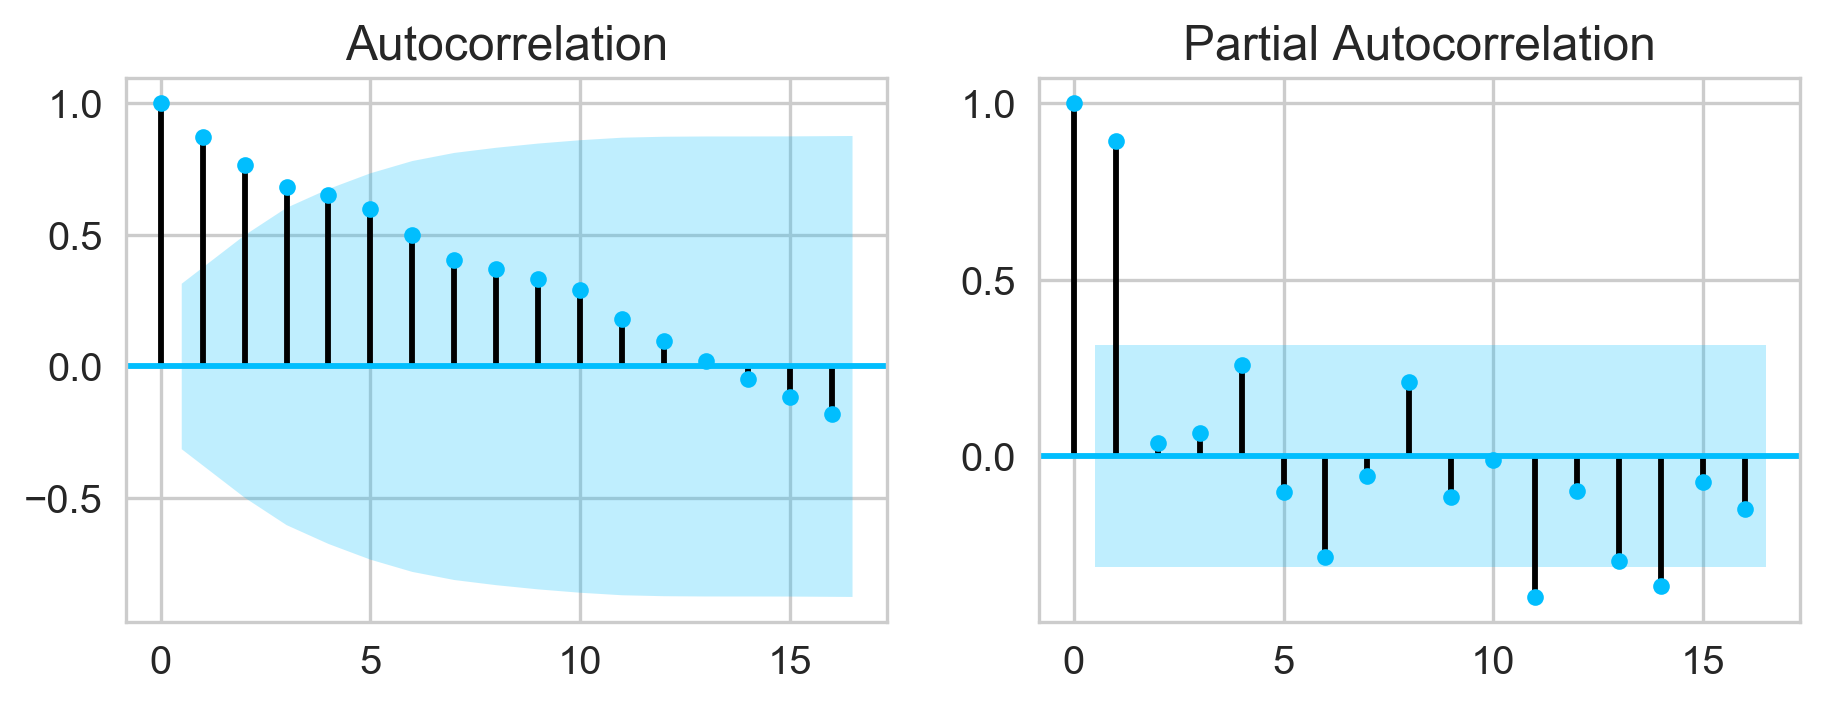

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(train, ax=axes[0]); 
plot_pacf(train, ax=axes[1]);

The ACF and PACF don't die pretty fast which indacates that the series are not stationary.
Let's plot the first order differencing.

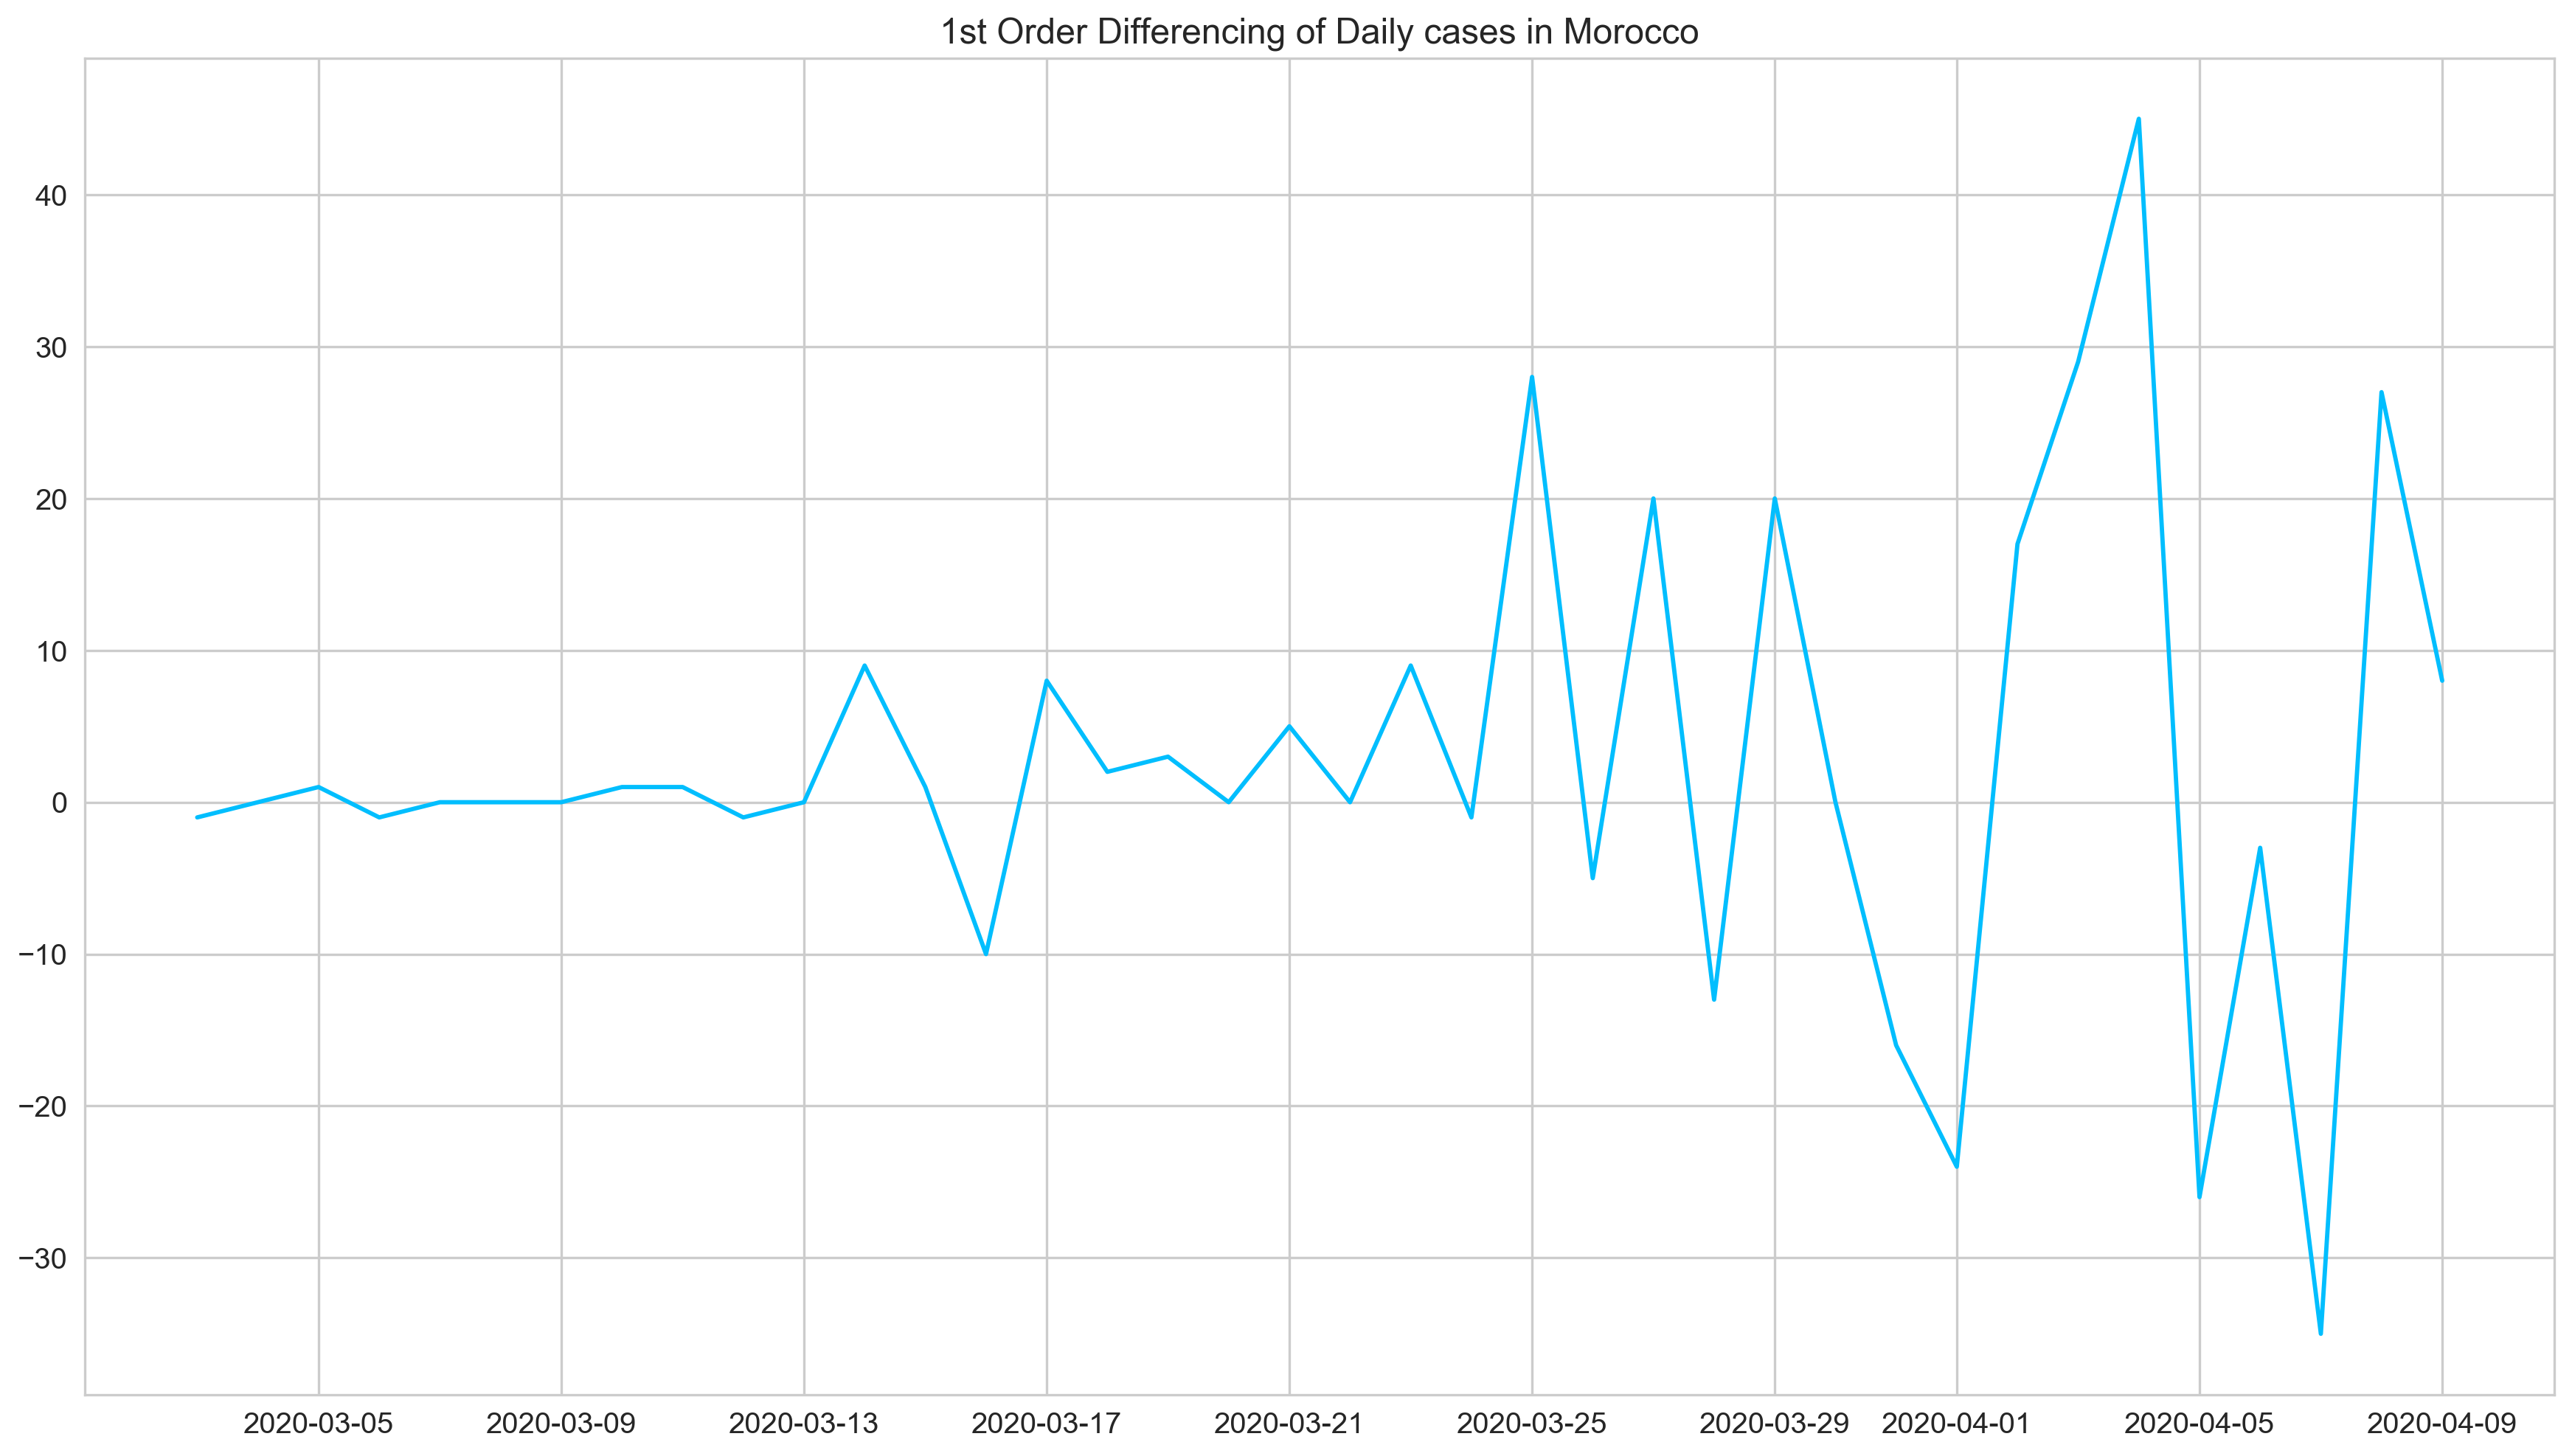

In [14]:
rcParams['figure.figsize'] = 18, 10

# 1st Differencing
plt.plot(train.diff().dropna())
plt.title("1st Order Differencing of Daily cases in Morocco");

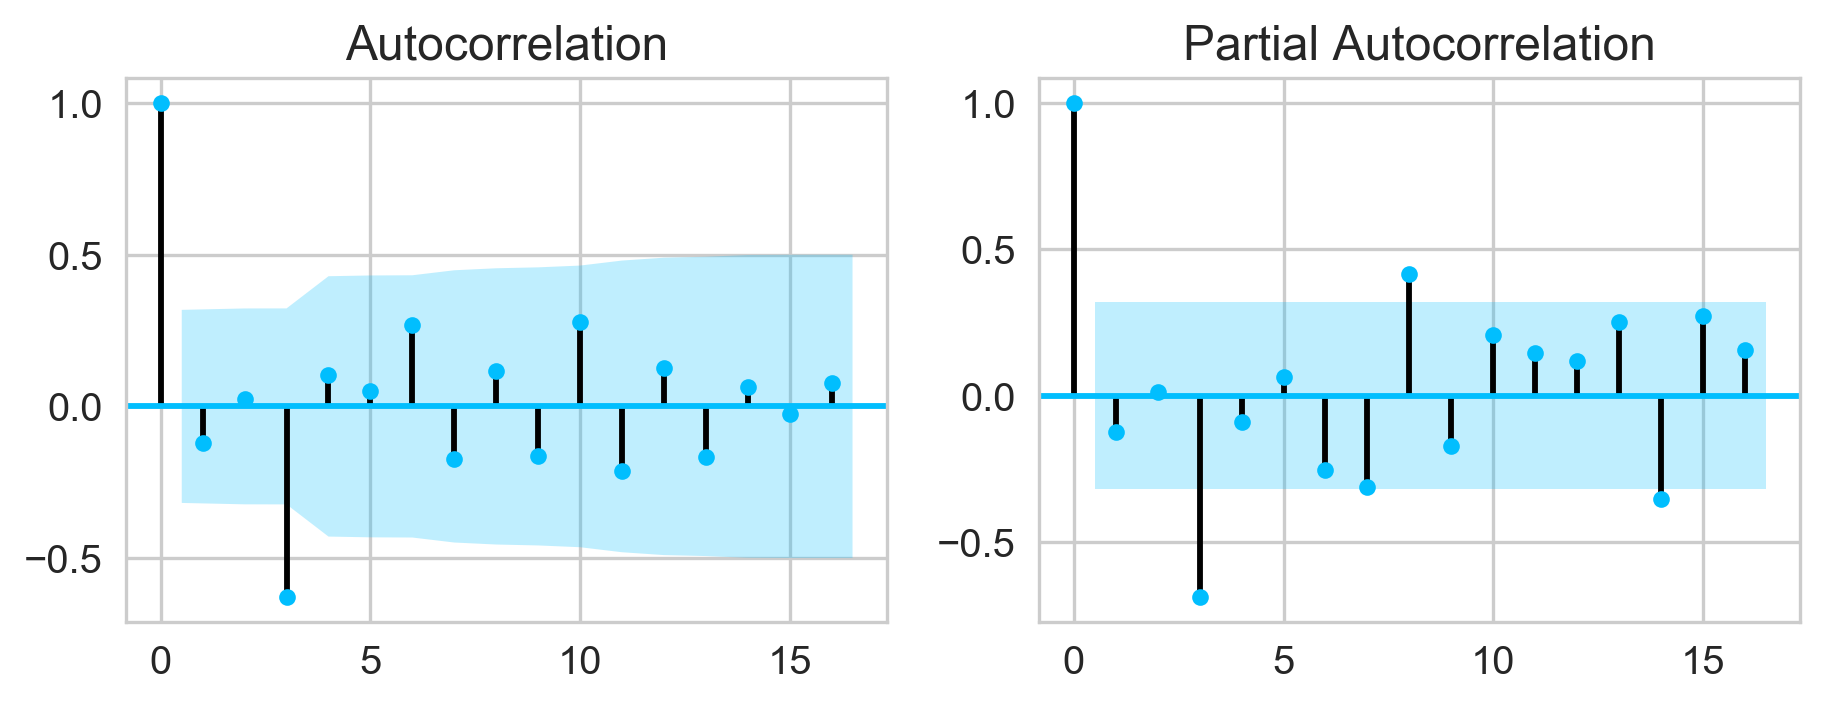

In [15]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(train.diff().dropna(), ax=axes[0]); 
plot_pacf(train.diff().dropna(), ax=axes[1]);

Now things seem pretty nice, everything is dying with this CoronaVirus, even my motivation to complete this tuto :)
# Fitting the ARIMA model

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA(1, 1, 2) Model, first try
model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                    163   No. Observations:                   39
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -153.852
Date:                Wed, 15 Apr 2020   AIC                            315.704
Time:                        21:01:11   BIC                            322.254
Sample:                    03-02-2020   HQIC                           318.035
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7270      0.187     -3.893      0.000      -1.093      -0.361
ar.L2          0.2472      0.109      2.267      0.023       0.033       0.461
ma.L1          0.8407      0.246      3.421      0.0

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Ps: Notice that ma.L1 = 0.8407 which veeeeery close to 1, this might interfere with the prediction step because the stochastic process might not be invisible after all :( you might want to go back and try the BoxCox transformation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) and see if you can make the series more stationary or just change the model parameters p, q. let's consider this model anyway and check what we can change in the diagnostic step.

# Diagnostic

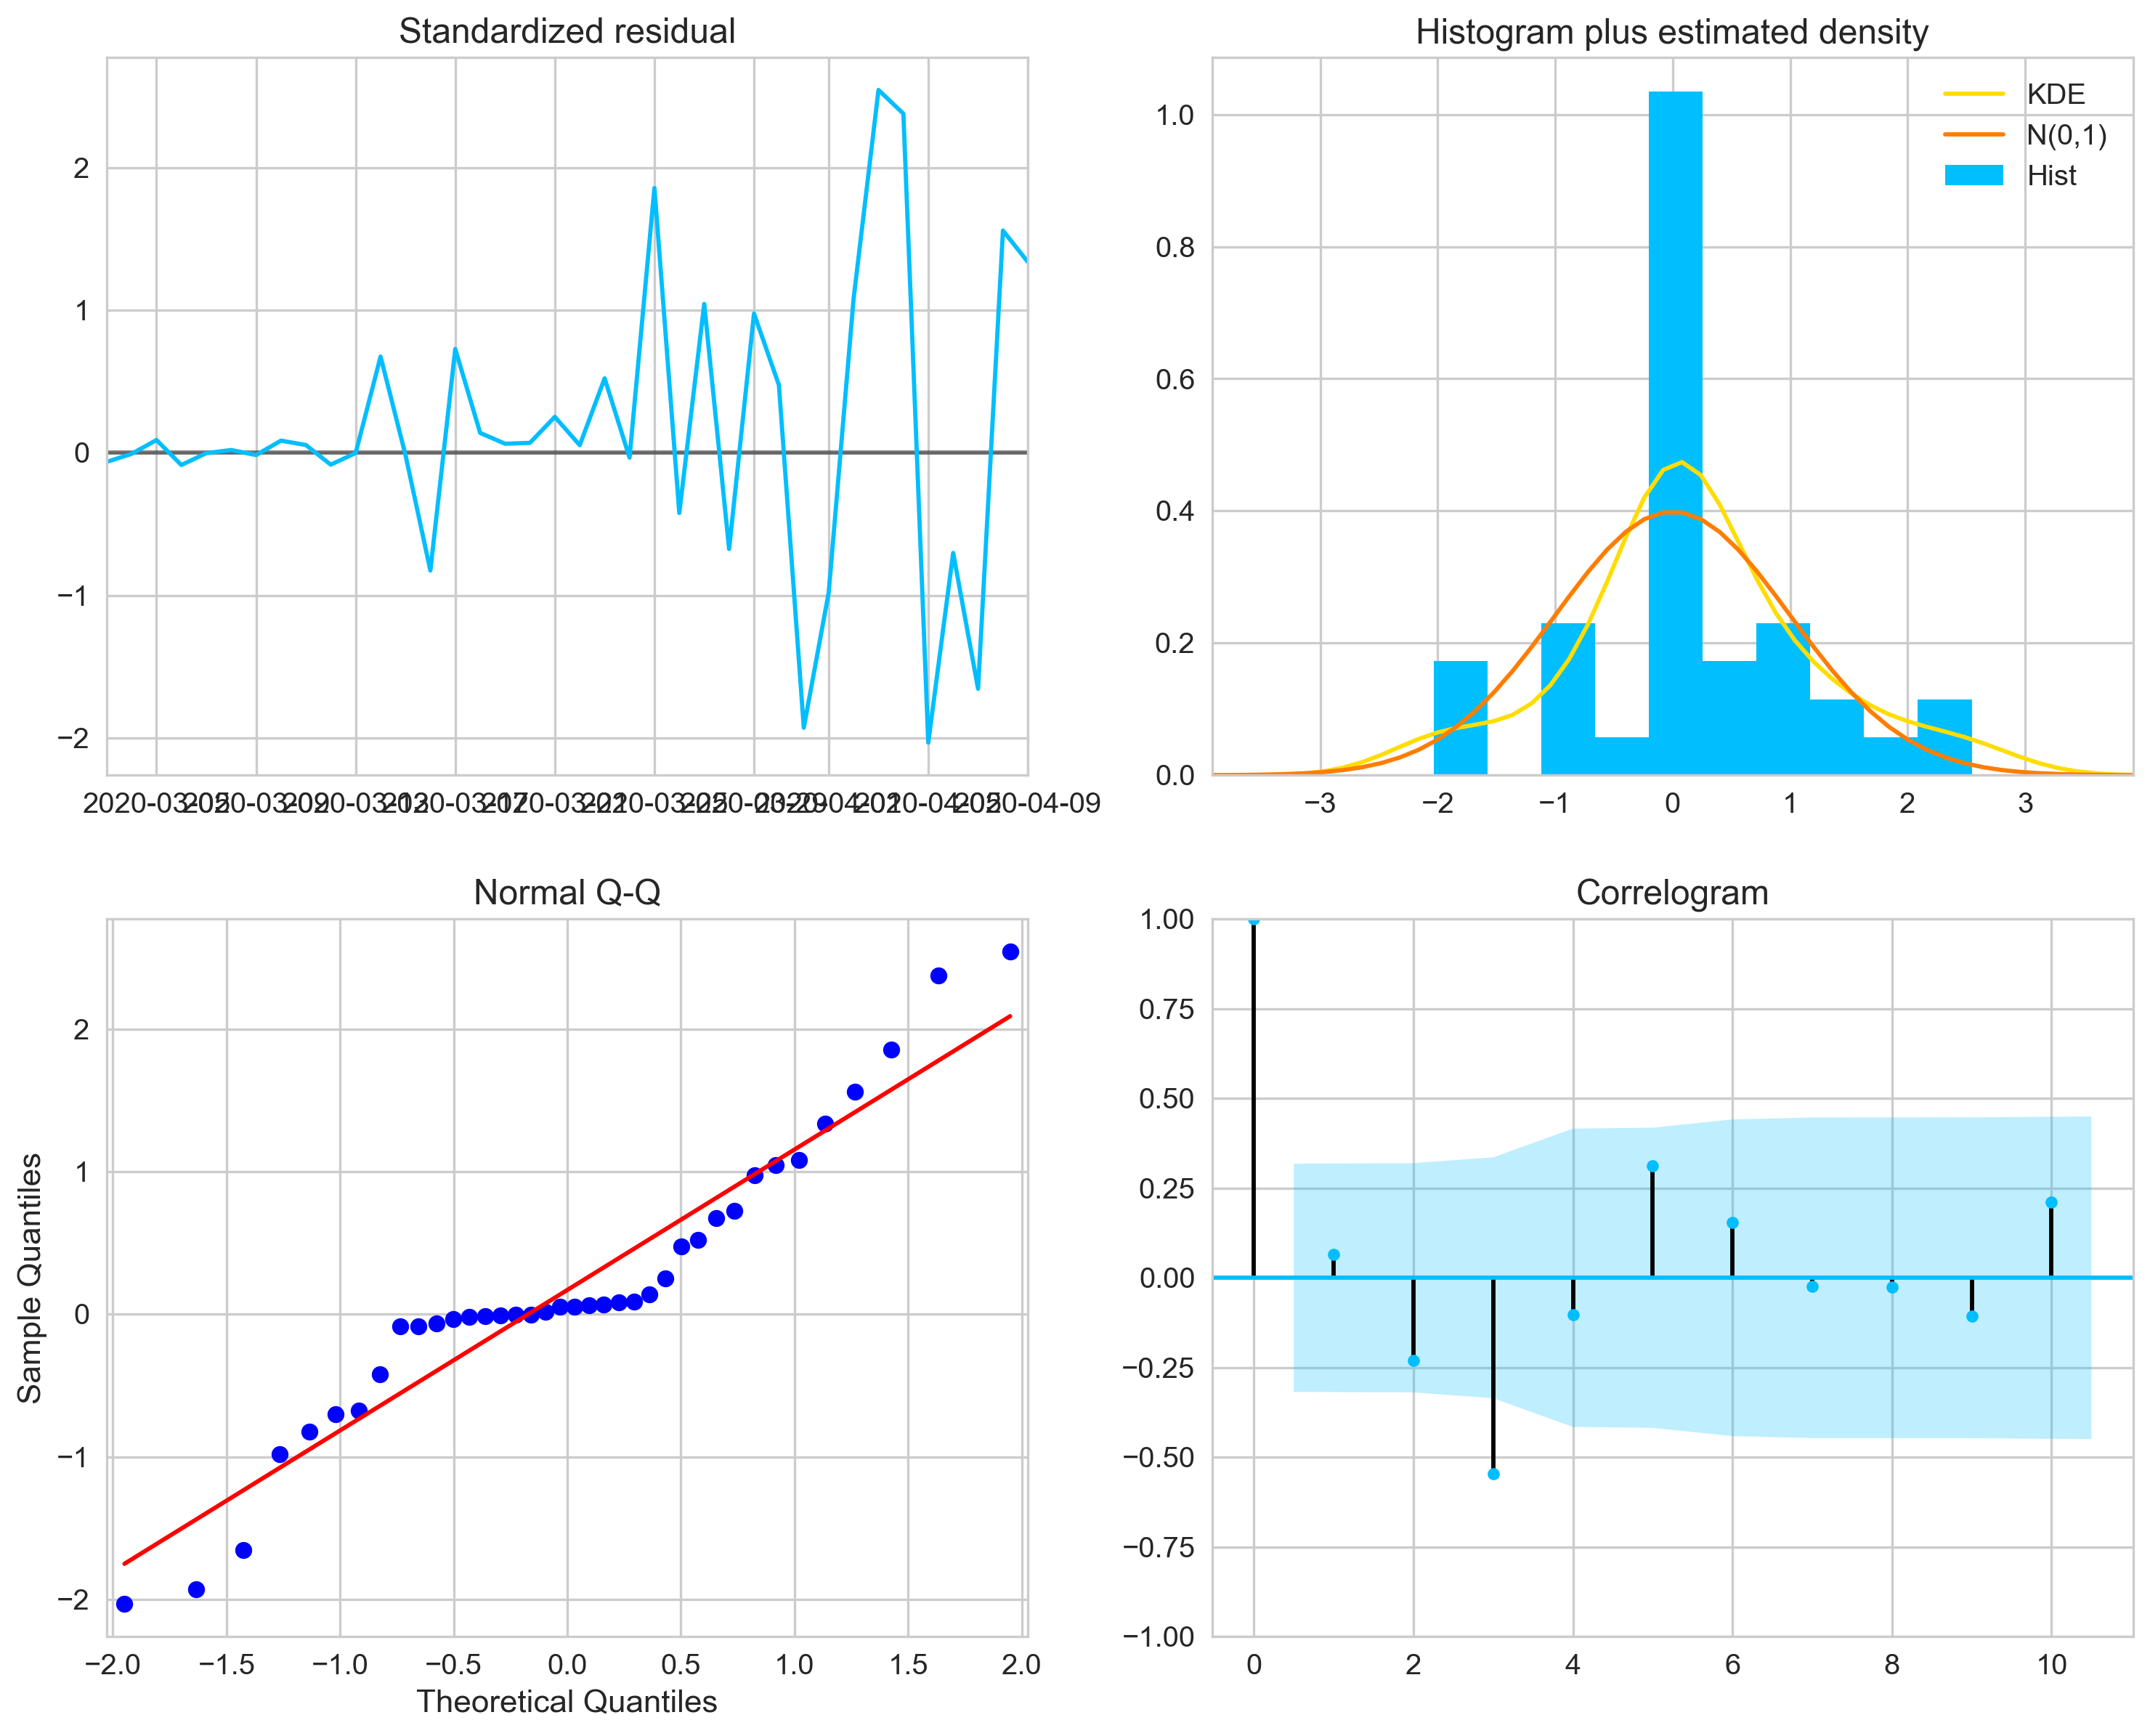

In [17]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting

In [18]:
forecast = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)

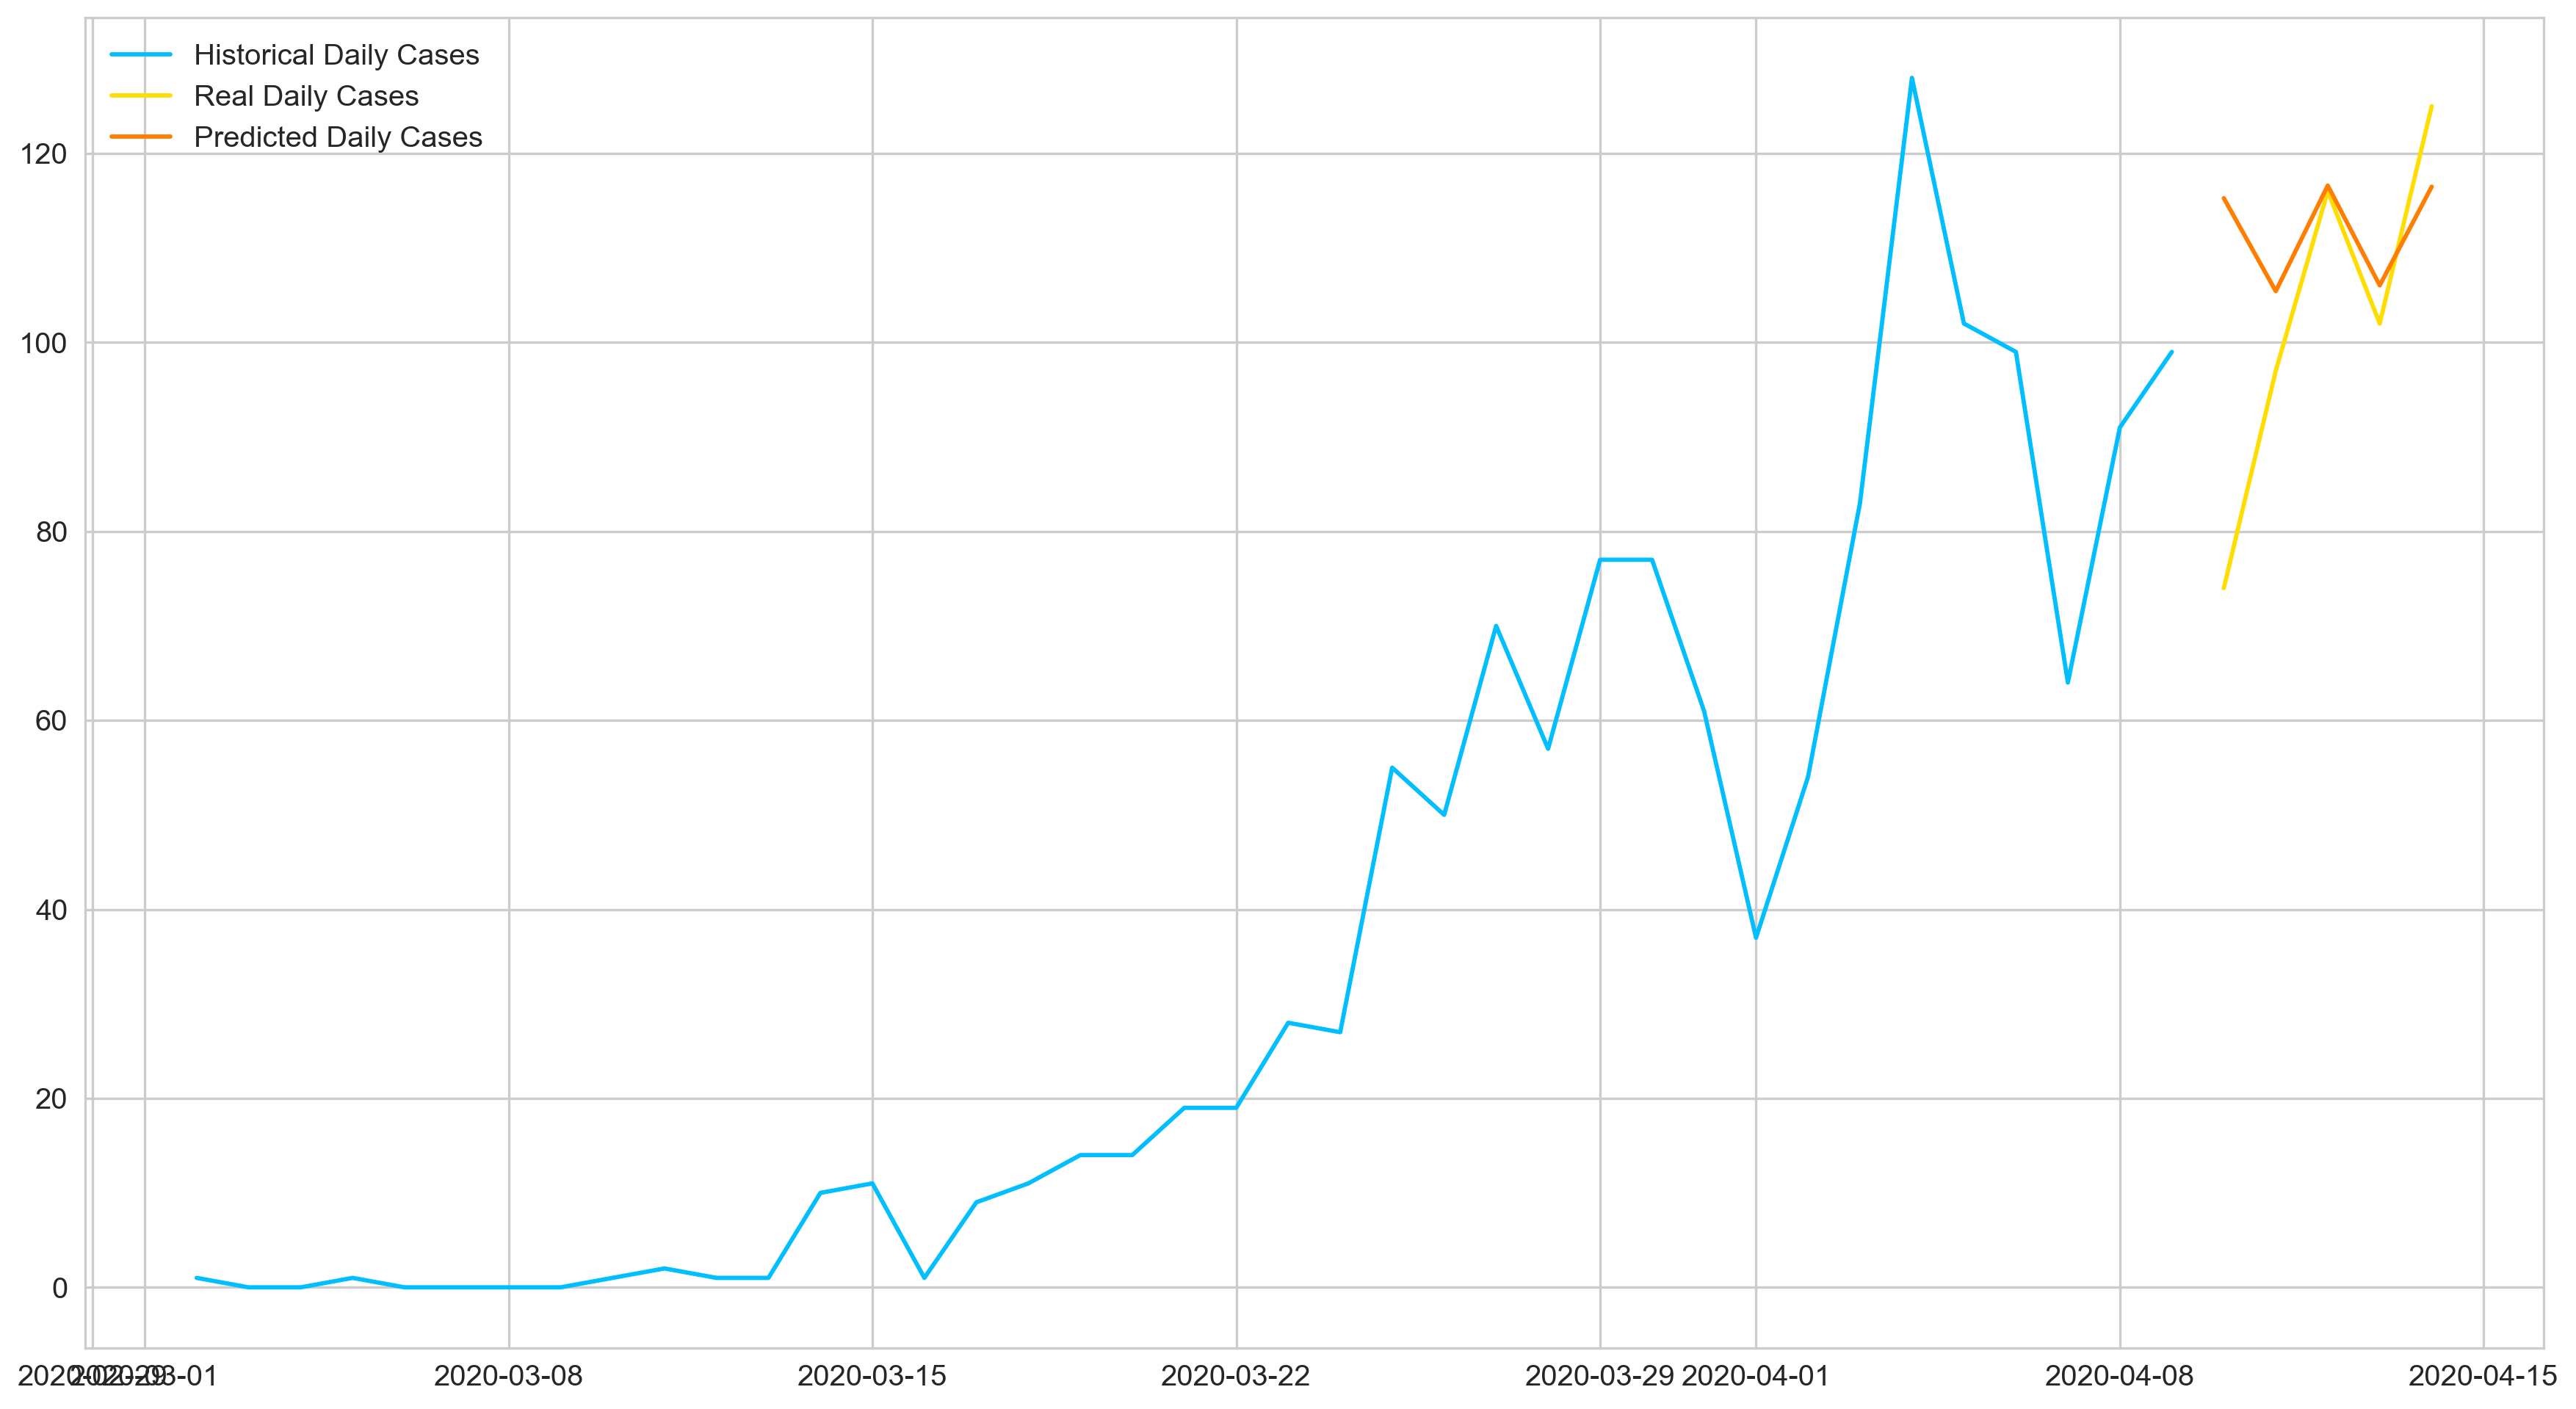

In [19]:
rcParams['figure.figsize'] = 18, 10

plt.plot(
  daily_cases.index[:len(train)], 
  train,
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train):len(train) + len(test)], 
  test,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train):len(train) + len(test)], 
  forecast, 
  label='Predicted Daily Cases'
)
plt.legend();

In [20]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

In [21]:
forecast_accuracy(forecast.values, test.values.transpose())

{'corr': 0.24366365030801837,
 'mae': 12.569371298488392,
 'mape': 15.14841025504921,
 'me': 9.162851136413025,
 'mpe': 0.12423194125388917,
 'rmse': 19.304571923414436}

# End

I'm sure you can find a more fit model for the CoronaVirus, so far we don't have enough data that can build a more precise model. this is just a quick Tuto for you guys so you can play with it a bit and open more on Data science with Python. Enjoy